# PC-Hazard Example 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

In [3]:
path_to_file = './../dataset_and_other_models/dataset/'
df_train_x = pd.read_csv(path_to_file + 'train_x.csv')
df_train_y = pd.read_csv(path_to_file + 'train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [4]:
df_test_x = pd.read_csv(path_to_file + 'test_x.csv')
df_test_y = pd.read_csv(path_to_file + 'test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [5]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [6]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [7]:
df_val = df_train.sample(frac=0.2, random_state=12)
df_train = df_train.drop(df_val.index)

In [8]:
df_train.head()

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DC,DE,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
2,2.0,2.0,2.0,2.0,1.5,3.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,2.0,2.0,66.0,2.0,2.0,0.0,645.0
3,2.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,...,2.0,10.0,2.0,2.0,2.0,72.0,2.0,2.0,0.0,2006.0
4,2.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,...,2.0,10.0,2.0,2.0,2.0,51.0,2.0,2.0,0.0,1933.0
5,2.0,1.0,1.0,3.0,2.5,3.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,67.0,2.0,2.0,1.0,467.0
7,2.0,2.0,6.0,2.0,3.2,3.0,2.0,1.0,1.0,1.0,...,2.0,8.0,2.0,2.0,2.0,91.0,2.0,2.0,0.0,37.0


## Feature transforms

In [9]:
cols_standardize =  ['BE', 'BC', 'AY', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AQ', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

21


In [10]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [11]:
df_train.head(4)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DC,DE,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
2,1.0,1.0,2.0,2.0,1.5,3.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,66.0,1.0,1.0,0.0,645.0
3,1.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,1.0,10.0,1.0,1.0,1.0,72.0,1.0,1.0,0.0,2006.0
4,1.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,...,1.0,10.0,1.0,1.0,1.0,51.0,1.0,1.0,0.0,1933.0
5,1.0,0.0,1.0,3.0,2.5,3.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,67.0,1.0,1.0,1.0,467.0


In [12]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong(min_per_category=5)) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [13]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [14]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

## Label transforms

In [15]:
num_durations = 20
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [16]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

## Neural net

In [17]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [137]:
# Opt1: {'num_nodes': [32, 64, 64, 64, 32], 'dropout': 0.8, 'lr': 0.001}
# Opt2: {'num_nodes': [16, 16, 16], 'dropout': 0.8, 'lr': 0.05}
# Opt3: {'num_nodes': [16, 16, 16, 16], 'dropout': 0.8, 'lr': 0.001}
# Opt4: {'num_nodes': [32, 64, 64, 64, 32], 'dropout': 0.8, 'lr': 0.001}
# Opt5: {'num_nodes': [32, 32, 32], 'dropout': 0.8, 'lr': 0.05}

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [16, 32, 16]
batch_norm = True
dropout = 0.8

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

## Training the model

In [138]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

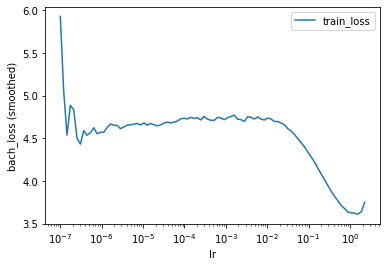

In [139]:
batch_size = 128
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [140]:

lr_finder.get_best_lr()

0.15556761439304817

In [141]:
model.optimizer.set_lr(0.05)

In [142]:
epochs = 1024
callbacks = []#[tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.2664,	val_loss: 4.1839
1:	[0s / 0s],		train_loss: 3.4321,	val_loss: 3.0306
2:	[0s / 0s],		train_loss: 2.8965,	val_loss: 1.8623
3:	[0s / 0s],		train_loss: 2.1105,	val_loss: 1.3025
4:	[0s / 0s],		train_loss: 1.8859,	val_loss: 1.1225
5:	[0s / 0s],		train_loss: 1.9760,	val_loss: 1.0684
6:	[0s / 0s],		train_loss: 1.4266,	val_loss: 1.0432
7:	[0s / 0s],		train_loss: 1.1747,	val_loss: 1.0306
8:	[0s / 0s],		train_loss: 1.1451,	val_loss: 1.0203
9:	[0s / 0s],		train_loss: 1.1657,	val_loss: 1.0223
10:	[0s / 0s],		train_loss: 1.1239,	val_loss: 1.0290
11:	[0s / 0s],		train_loss: 1.0800,	val_loss: 1.0320
12:	[0s / 0s],		train_loss: 1.0367,	val_loss: 1.0426
13:	[0s / 0s],		train_loss: 1.0546,	val_loss: 1.0355
14:	[0s / 0s],		train_loss: 1.0060,	val_loss: 1.0111
15:	[0s / 0s],		train_loss: 1.0767,	val_loss: 1.0032
16:	[0s / 0s],		train_loss: 0.9593,	val_loss: 1.0018
17:	[0s / 0s],		train_loss: 1.0268,	val_loss: 1.0183
18:	[0s / 0s],		train_loss: 1.0162,	val_loss: 0.9944
19:

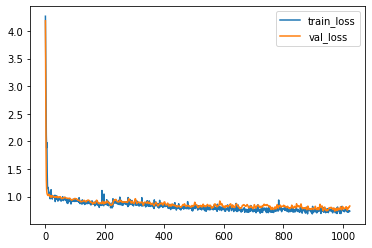

In [143]:
_ = log.plot()

## Prediction

In [144]:
surv = model.predict_surv_df(x_test)

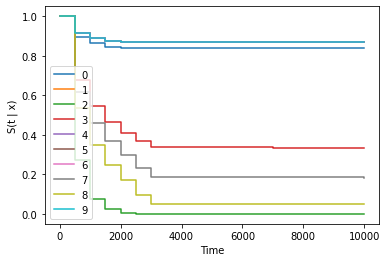

In [145]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [146]:
model.sub = 20

In [147]:
surv = model.predict_surv_df(x_test)
surv_train = model.predict_surv_df(x_train)
surv_val = model.predict_surv_df(x_val)

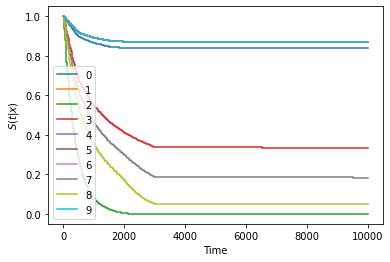

In [148]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

## Evaluation

In [149]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

0.7768410185822436

In [150]:
durations_train, events_train = get_target(df_train)
ev_train = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')
ev_train.concordance_td()

0.8114671299850499

In [151]:
durations_val, events_val = get_target(df_val)
ev_val = EvalSurv(surv_val, durations_val, events_val, censor_surv='km')
ev_val.concordance_td()

0.7653005464480874

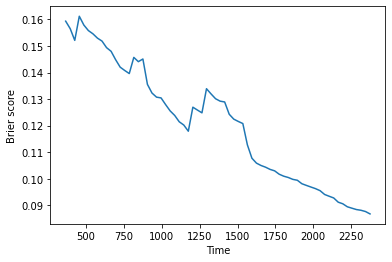

In [152]:
# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid = np.arange(365, 2400, 30)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [153]:
ev.integrated_brier_score(time_grid) 

0.12066537424695692

In [154]:
ev_train.integrated_brier_score(time_grid)

0.10522095892310104

In [155]:
ev_val.integrated_brier_score(time_grid)

0.13800705722914944

In [28]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features

nets = [[32, 32, 32, 32], [16, 16, 16, 16], [64, 64, 64, 64], [32, 32, 32], [16, 16, 16], [64, 64, 64], [32, 32], [64, 128, 64], [64, 64],
       [32, 64, 64, 64, 32]]
droputs = [0.1, 0.6, 0.7,  0.8]
lrs = [0.001, 0.01, 0.05]


epochs = 512
callbacks = [] #[tt.cb.EarlyStoppingCycle()]
verbose = False

cv = []

for num_nodes in nets:
    for dropout in droputs:
        for lr in lrs:
            params = {'num_nodes': num_nodes, 'dropout': dropout, 'lr': lr}
            print(params)
            batch_norm = True
            net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

            model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

            model.optimizer.set_lr(lr)

            log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)


            model.sub = 10
            surv_train = model.predict_surv_df(x_train)
            surv_val = model.predict_surv_df(x_val)

            ev_train = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')
            ev_val = EvalSurv(surv_val, durations_val, events_val, censor_surv='km')

            score = {'Validation Error': ev_val.concordance_td(),  'Train Error': ev_train.concordance_td()}
            print(score)

            cv.append([params, score['Validation Error']])

            print('---------------')


{'num_nodes': [32, 32, 32, 32], 'dropout': 0.1, 'lr': 0.001}
{'Validation Error': 0.7622950819672131, 'Train Error': 0.9345024041375409}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.1, 'lr': 0.01}
{'Validation Error': 0.6934426229508197, 'Train Error': 0.9363206594205826}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.1, 'lr': 0.05}
{'Validation Error': 0.7131147540983607, 'Train Error': 0.930502242514849}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.6, 'lr': 0.001}
{'Validation Error': 0.753551912568306, 'Train Error': 0.8130833569033092}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.6, 'lr': 0.01}
{'Validation Error': 0.7557377049180328, 'Train Error': 0.8522364539981413}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.6, 'lr': 0.05}
{'Validation Error': 0.759016393442623, 'Train Error': 0.8488423774697967}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.7, 'lr': 0.001}
{'Validation Error': 0.71857

In [143]:

with open('hyperparameters_PCH.npy', 'wb') as f:
    np.save(f, np.array(cv))


In [ ]:
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.6, 'lr': 0.05}
{'Validation Error': 0.7718089990817264, 'Train Error': 0.8220109513207774}

{'num_nodes': [16, 16, 16, 16], 'dropout': 0.1, 'lr': 0.05}
{'Validation Error': 0.7975206611570248, 'Train Error': 0.9016788013719237}

{'num_nodes': [64, 64, 64, 64], 'dropout': 0.6, 'lr': 0.01}
{'Validation Error': 0.7865013774104683, 'Train Error': 0.8738792947830796}

{'num_nodes': [64, 64, 64], 'dropout': 0.6, 'lr': 0.05}
{'Validation Error': 0.7855831037649219, 'Train Error': 0.8702087971598772}

#-------------
{'num_nodes': [16, 16, 16], 'dropout': 0.8, 'lr': 0.05}
{'num_nodes': [16, 16, 16, 16], 'dropout': 0.8, 'lr': 0.001}
{'num_nodes': [32, 64, 64, 64, 32], 'dropout': 0.7, 'lr': 0.001}
{'num_nodes': [32, 64, 64, 64, 32], 'dropout': 0.8, 'lr': 0.001}